# Robot Predictive Maintenance - MLOps Workshop

## Univariate Linear Regression for Maintenance Prediction

This notebook demonstrates a complete machine learning workflow for predictive maintenance using univariate linear regression.

### Workshop Objectives
1. Define a univariate regression problem for robot maintenance
2. Implement linear regression from scratch AND with scikit-learn
3. Evaluate and compare models
4. Generate maintenance alerts based on predictions
5. Apply MLOps best practices

---
## Prompt 1: Problem Definition (UNIVARIATE)

### Problem Statement

**Objective:** Predict robot motor degradation over time using univariate linear regression.

**Variables:**
- **X (Independent Variable):** `elapsed_hours` - Time elapsed since monitoring began
- **y (Dependent Variable):** `mean_current` - Average current draw across all motor axes

**Why Univariate?**
- Single predictor (time) maps directly to single outcome (current)
- Allows clear interpretation: slope = degradation rate (Amps/hour)
- Foundation for understanding before multivariate expansion

**Maintenance Relevance:**
- **Positive slope** indicates increasing current draw = motor degradation
- **Slope magnitude** quantifies degradation speed
- **Prediction** enables proactive maintenance scheduling

### Mathematical Model
```
mean_current = slope * elapsed_hours + intercept
```

Where:
- `slope` = degradation rate (A/hour)
- `intercept` = baseline current at t=0

---
## Cell 1: Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from datetime import datetime

# Import custom modules
from data_loader import load_csv, compute_features, get_data_summary
from preprocessing import handle_missing_values, scale_features, temporal_train_test_split
from model import LinearRegressionScratch, train_sklearn_model, compare_models
from evaluation import compute_metrics, print_metrics, plot_regression
from alert_system import generate_alerts_for_fleet, print_alerts

print("Modules imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Modules imported successfully
NumPy version: 2.4.1
Pandas version: 3.0.0


---
## Cell 2: Load Configuration

In [2]:
# Load experiment configuration
with open('../configs/experiment_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  Data source: {config['data']['source']}")
print(f"  Feature (X): {config['model']['feature']}")
print(f"  Target (y): {config['model']['target']}")
print(f"  Train/Test split: {config['preprocessing']['train_test_split']['ratio']}")
print(f"  Learning rate: {config['model']['gradient_descent']['learning_rate']}")
print(f"  Iterations: {config['model']['gradient_descent']['n_iterations']}")

Configuration loaded:
  Data source: csv
  Feature (X): elapsed_hours
  Target (y): mean_current
  Train/Test split: 0.8
  Learning rate: 0.01
  Iterations: 100


---
## Prompt 2: Data Preprocessing

### Preprocessing Pipeline

1. **Missing Values:** Forward fill (preserves temporal order)
2. **Feature Scaling:** MinMax normalization to [0,1]
3. **Train/Test Split:** Temporal (80/20) - no future leakage

In [3]:
# Load data
data_path = config['data']['csv_path']
df = load_csv(data_path)

# Data summary
summary = get_data_summary(df)
print(f"\nDataset Summary:")
print(f"  Records: {summary['record_count']:,}")
print(f"  Axes: {summary['axis_count']}")

Loading data from: ../data/raw/all_robots_combined.csv


Loaded 158,688 records

Dataset Summary:
  Records: 158,688
  Axes: 14


In [4]:
# Compute features
df = compute_features(df)

# Handle missing values
df = handle_missing_values(df, strategy='forward_fill')

# Temporal train/test split
train_df, test_df = temporal_train_test_split(df, train_ratio=0.8)

print(f"\nPreprocessing complete:")
print(f"  Training samples: {len(train_df):,}")
print(f"  Test samples: {len(test_df):,}")

Computed 6 new features
Missing values: 436392 -> 158688 (strategy: forward_fill)
Temporal split: 126,950 train, 31,738 test (80%/20%)

Preprocessing complete:
  Training samples: 126,950
  Test samples: 31,738


---
## Prompt 3: Linear Regression FROM SCRATCH

### Mathematical Components

1. **Hypothesis:** h(x) = w*x + b
2. **Cost (MSE):** J = (1/2m) * sum((h(x) - y)^2)
3. **Gradients:** dw = (1/m) * sum((h(x) - y) * x), db = (1/m) * sum(h(x) - y)
4. **Update:** w := w - alpha * dw, b := b - alpha * db

In [5]:
# Prepare data
feature = config['model']['feature']
target = config['model']['target']

X_train = train_df[feature].values
y_train = train_df[target].values
X_test = test_df[feature].values
y_test = test_df[target].values

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

Training data shape: X=(126950,), y=(126950,)
Test data shape: X=(31738,), y=(31738,)


In [6]:
# Train from-scratch model
lr = config['model']['gradient_descent']['learning_rate']
n_iter = config['model']['gradient_descent']['n_iterations']

scratch_model = LinearRegressionScratch(learning_rate=lr, n_iterations=n_iter)
scratch_model.fit(X_train, y_train)

# Get predictions
y_pred_train_scratch = scratch_model.predict(X_train)
y_pred_test_scratch = scratch_model.predict(X_test)

Training Linear Regression (from scratch)
  Learning rate: 0.01
  Iterations: 100
  Samples: 126950
  Iteration     0: Cost = 17.378237, w = 0.518371, b = 0.056352
  Iteration    10: Cost = 17.084556, w = 0.459697, b = 0.180869
  Iteration    20: Cost = 16.926240, w = 0.449232, b = 0.306329
  Iteration    30: Cost = 16.775367, w = 0.439016, b = 0.428806
  Iteration    40: Cost = 16.631585, w = 0.429043, b = 0.548369
  Iteration    50: Cost = 16.494562, w = 0.419307, b = 0.665088
  Iteration    60: Cost = 16.363980, w = 0.409803, b = 0.779031
  Iteration    70: Cost = 16.239536, w = 0.400525, b = 0.890263
  Iteration    80: Cost = 16.120942, w = 0.391468, b = 0.998850
  Iteration    90: Cost = 16.007923, w = 0.382626, b = 1.104854
  Iteration    99: Cost = 15.910754, w = 0.374848, b = 1.198100

Final parameters:
  Weight (slope): 0.374848
  Bias (intercept): 1.198100


---
## Prompt 4: Linear Regression with scikit-learn

In [7]:
# Train sklearn model
sklearn_model, sklearn_coef = train_sklearn_model(X_train, y_train)

# Get predictions
y_pred_train_sklearn = sklearn_model.predict(X_train.reshape(-1, 1))
y_pred_test_sklearn = sklearn_model.predict(X_test.reshape(-1, 1))

Training Linear Regression (scikit-learn)
  Samples: 126950

Final parameters:
  Weight (slope): 0.019739
  Bias (intercept): 5.455409


In [8]:
# Compare models
comparison = compare_models(scratch_model, sklearn_coef)


MODEL COMPARISON
Parameter       From Scratch    Scikit-learn    Difference     
------------------------------------------------------------
Slope           0.374848        0.019739        0.355109       
Intercept       1.198100        5.455409        4.257309       
------------------------------------------------------------
Models match: NO (check learning rate/iterations)


---
## Prompt 5: Model Evaluation & Visualization

In [9]:
# Evaluate from-scratch model
metrics_scratch = compute_metrics(y_test, y_pred_test_scratch)
print_metrics(metrics_scratch, "From-Scratch Model")

# Evaluate sklearn model
metrics_sklearn = compute_metrics(y_test, y_pred_test_sklearn)
print_metrics(metrics_sklearn, "Scikit-learn Model")


EVALUATION METRICS: From-Scratch Model
  RMSE:      8.425595
  MAE:       6.499402
  R2 Score:  0.004556
  MSE:       70.990643
  Samples:   31738

EVALUATION METRICS: Scikit-learn Model
  RMSE:      8.632442
  MAE:       6.061877
  R2 Score:  -0.044920
  MSE:       74.519054
  Samples:   31738


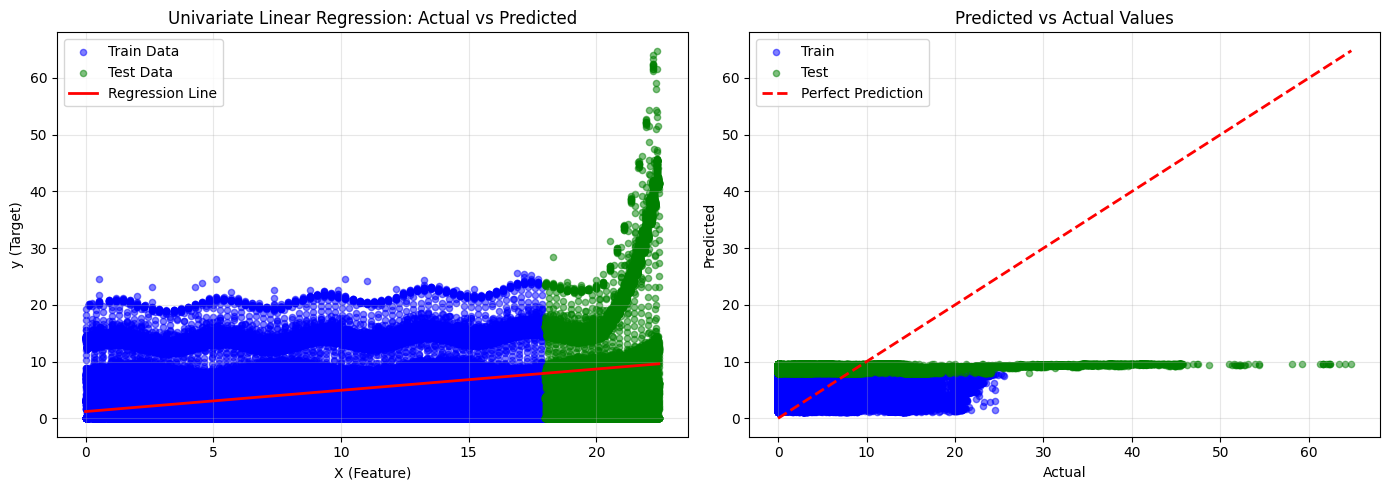

In [10]:
# Visualize regression
fig = plot_regression(
    X_train, y_train, X_test, y_test,
    y_pred_train_scratch, y_pred_test_scratch,
    model_name="Univariate Linear Regression"
)
plt.show()

---
## Prompt 12: Failure Prediction & Alerts (Fleet-Wide)

This cell processes each robot individually:
1. Trains a separate regression model per robot
2. Computes degradation slope for each
3. Generates maintenance alerts for the entire fleet

In [11]:
# Prepare regression results for ALL robots in the fleet
# First, check if data has robot_id column and process each robot separately

if 'robot_id' in df.columns:
    robot_ids = df['robot_id'].unique()
    print(f"Found {len(robot_ids)} robots: {list(robot_ids)}")
    
    # Store models and results per robot
    robot_models = {}
    regression_results = {}
    
    for robot_id in robot_ids:
        # Filter data for this robot
        robot_df = df[df['robot_id'] == robot_id].copy()
        
        # Recompute elapsed_hours relative to this robot's start time
        time_col = 'Time' if 'Time' in robot_df.columns else 'timestamp'
        robot_df['elapsed_hours'] = (robot_df[time_col] - robot_df[time_col].min()).dt.total_seconds() / 3600
        
        # Split for this robot
        robot_train, robot_test = temporal_train_test_split(robot_df, train_ratio=0.8)
        
        X_train_r = robot_train[feature].values
        y_train_r = robot_train[target].values
        X_test_r = robot_test[feature].values
        
        # Train model for this robot
        model = LinearRegressionScratch(learning_rate=lr, n_iterations=n_iter)
        model.fit(X_train_r, y_train_r)
        
        # Store model and results
        robot_models[robot_id] = {
            'model': model,
            'X_train': X_train_r,
            'y_train': y_train_r,
            'X_test': X_test_r,
            'y_test': robot_test[target].values
        }
        
        regression_results[robot_id] = {
            'slope': model.weight,
            'intercept': model.bias,
            'current_hours': X_test_r.max(),
            'baseline_value': model.bias
        }
        
        print(f"  {robot_id}: slope={model.weight:.6f}, intercept={model.bias:.4f}")
else:
    # Fallback for single robot data without robot_id column
    robot_ids = ['Robot_A']
    robot_models = {
        'Robot_A': {
            'model': scratch_model,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        }
    }
    regression_results = {
        'Robot_A': {
            'slope': scratch_model.weight,
            'intercept': scratch_model.bias,
            'current_hours': X_test.max(),
            'baseline_value': scratch_model.bias
        }
    }

# Generate alerts for the entire fleet
alerts = generate_alerts_for_fleet(regression_results)
print_alerts(alerts)

Found 4 robots: ['Robot_A', 'Robot_B', 'Robot_C', 'Robot_D']
Temporal split: 31,737 train, 7,935 test (80%/20%)
Training Linear Regression (from scratch)
  Learning rate: 0.01
  Iterations: 100
  Samples: 31737
  Iteration     0: Cost = 2.104180, w = 0.097648, b = 0.011843
  Iteration    10: Cost = 2.086434, w = 0.085585, b = 0.047334
  Iteration    20: Cost = 2.073841, w = 0.082633, b = 0.082717
  Iteration    30: Cost = 2.061841, w = 0.079752, b = 0.117259
  Iteration    40: Cost = 2.050405, w = 0.076939, b = 0.150979
  Iteration    50: Cost = 2.039507, w = 0.074194, b = 0.183896
  Iteration    60: Cost = 2.029120, w = 0.071513, b = 0.216031
  Iteration    70: Cost = 2.019222, w = 0.068896, b = 0.247401
  Iteration    80: Cost = 2.009790, w = 0.066342, b = 0.278025
  Iteration    90: Cost = 2.000800, w = 0.063848, b = 0.307921
  Iteration    99: Cost = 1.993072, w = 0.061655, b = 0.334219

Final parameters:
  Weight (slope): 0.061655
  Bias (intercept): 0.334219
  Robot_A: slope=0.06

  Iteration    60: Cost = 5.889632, w = 0.501483, b = 0.968831
  Iteration    70: Cost = 5.696880, w = 0.489936, b = 1.107266
  Iteration    80: Cost = 5.513189, w = 0.478663, b = 1.242407
  Iteration    90: Cost = 5.338133, w = 0.467659, b = 1.374334
  Iteration    99: Cost = 5.187629, w = 0.457979, b = 1.490384

Final parameters:
  Weight (slope): 0.457979
  Bias (intercept): 1.490384
  Robot_D: slope=0.457979, intercept=1.4904

MAINTENANCE ALERT REPORT
Generated: 2026-01-30 14:29:41

[!!!] CRITICAL ALERTS
------------------------------------------------------------

  Robot_A: CRITICAL: Robot_A requires immediate maintenance - Predicted failure in 0.0 days
    Slope: 0.061655 A/hr
    Days to failure: 0.0
    Action: IMMEDIATE: Stop robot for inspection. Check motors, bearings, and drive systems.

  Robot_B: CRITICAL: Robot_B requires immediate maintenance - Predicted failure in 0.0 days
    Slope: 0.146984 A/hr
    Days to failure: 0.0
    Action: IMMEDIATE: Stop robot for inspecti

---
## Prompt 14: Experiment Tracking (Fleet-Wide)

Log results for ALL robots to experiments/results.csv for auditability.
Each robot gets its own row with metrics, slope, and alert status.

In [12]:
# Log experiment results for ALL robots
experiment_id = f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
experiment_results = []

# Create a mapping of robot_id to their alerts
alert_map = {alert.robot_id: alert for alert in alerts}

for robot_id in robot_ids:
    robot_data = robot_models[robot_id]
    model = robot_data['model']
    
    # Compute metrics for this robot
    y_pred_test = model.predict(robot_data['X_test'])
    robot_metrics = compute_metrics(robot_data['y_test'], y_pred_test)
    
    # Get alert for this robot
    robot_alert = alert_map.get(robot_id)
    
    experiment_result = {
        'timestamp': datetime.now().isoformat(),
        'experiment_id': experiment_id,
        'robot_id': robot_id,
        'feature': feature,
        'target': target,
        'model_version': '1.0',
        'train_samples': len(robot_data['X_train']),
        'test_samples': len(robot_data['X_test']),
        'rmse': robot_metrics.rmse,
        'mae': robot_metrics.mae,
        'r2': robot_metrics.r2,
        'slope': model.weight,
        'intercept': model.bias,
        'alert_level': robot_alert.level.value if robot_alert else 'NONE',
        'alert_threshold_crossed': robot_alert.level.value != 'NONE' if robot_alert else False,
        'notes': 'Fleet-wide experiment'
    }
    experiment_results.append(experiment_result)
    print(f"Logged: {robot_id} - RMSE: {robot_metrics.rmse:.4f}, R2: {robot_metrics.r2:.4f}, Alert: {experiment_result['alert_level']}")

# Append all results to file
results_df = pd.DataFrame(experiment_results)
results_df.to_csv('../experiments/results.csv', mode='a', header=False, index=False)
print(f"\nExperiment {experiment_id} logged to results.csv ({len(experiment_results)} robots)")

Logged: Robot_A - RMSE: 2.0907, R2: 0.0079, Alert: CRITICAL
Logged: Robot_B - RMSE: 1.8400, R2: -0.1919, Alert: CRITICAL
Logged: Robot_C - RMSE: 9.9306, R2: 0.0813, Alert: CRITICAL
Logged: Robot_D - RMSE: 3.0704, R2: -0.6454, Alert: CRITICAL

Experiment exp_20260130_142941 logged to results.csv (4 robots)


---
## Summary

### What We Accomplished
1. Defined univariate regression problem (elapsed_hours -> mean_current)
2. Implemented preprocessing pipeline (missing values, scaling, temporal split)
3. Built linear regression from scratch using gradient descent
4. Compared with scikit-learn implementation
5. Evaluated models using RMSE, MAE, R2
6. **Fleet-wide processing:** Trained individual models per robot (Robot_A, Robot_B, Robot_C, Robot_D)
7. Generated maintenance alerts for the entire fleet with severity levels
8. Logged experiment results for all robots to enable fleet-wide tracking

### MLOps Principles Applied
- **Separation of concerns:** Modular code in src/
- **Configuration-driven:** YAML configs control experiments
- **Reproducibility:** Fixed seeds, versioned data, logged parameters
- **Experiment tracking:** Results logged to CSV (one row per robot per experiment)
- **Auditability:** Full lineage from data to alerts
- **Fleet management:** Individual models per robot for accurate per-unit monitoring